In [1]:
import pandas as pd

df = pd.read_csv('/Users/patwilliams/DSCI441/DSCI411-project/Data_PreProcessing/final_economic_data.csv')

In [2]:
df.head()

,Year,Annual_%_Change_nasdaq,Annual_%_Change_dowj,Annual_%_Change_sp500,Annual_%_Change_corn,Annual_%_Change_cotton,Annual_%_Change_pound,Annual_%_Change_yen,Annual_Unemployment_Rate,Annual_%_Change_silver,...,Annual_%_Change_FFRate,Annual_%_Change_tenyrRate,Annual_%_Change_oneyrRate,Annual_%_Change_gold,Annual_%_Change_crude,Annual_%_Change_copper,Annual_%_Change_coffee,Unemployment_Rate_Increased,Unemployment_Rate_Percent_Change,Unemployment_Rate_Change_Indicator
0,2024.0,9.05,5.55,9.89,-6.53,13.58,-0.51,6.85,3.800000,-0.092688,...,-0.223298,0.262182,-0.145917,-0.144743,0.056138,-0.134274,-0.345731,1,4.827586,0
1,2023.0,43.42,13.70,24.23,-30.62,-2.41,5.22,7.56,3.625000,-0.229543,...,-0.070694,-0.082794,-0.199847,0.188286,-0.582778,-0.166927,0.208869,0,-0.229358,0
2,2022.0,-33.10,-8.78,-19.44,14.37,-26.29,-10.52,13.91,3.633333,-0.124077,...,6.297961,3.488887,3.026747,-0.340666,-0.128344,-0.646130,-0.838549,0,-31.981279,1
3,2021.0,21.39,18.73,26.89,22.57,44.14,-1.23,11.49,5.341667,-0.569481,...,-0.370152,2.094849,3.026747,-0.471016,1.052936,0.566733,1.624098,0,-33.985582,1
4,2020.0,43.64,7.25,16.26,24.82,13.14,3.21,-5.00,8.091667,1.282133,...,-0.845809,-1.852644,-1.742681,0.639346,-0.807901,0.536434,-0.237071,1,120.181406,1


In [3]:
from sklearn.model_selection import TimeSeriesSplit

# Assuming the DataFrame is already sorted by year
# Extract the row for the holdout set (the most recent year, 2024)
holdout = df[df['Year'] == 2024]
holdout_features = holdout.drop(['Annual_Unemployment_Rate', 'Year', 'Unemployment_Rate_Increased', 'Unemployment_Rate_Percent_Change', 'Unemployment_Rate_Change_Indicator'], axis=1)


# Remove the holdout set from the main DataFrame
df_modeling = df[df['Year'] != 2024]

# Define the features and target without the holdout year
X = df_modeling.drop(['Annual_Unemployment_Rate', 'Year', 'Unemployment_Rate_Increased', 'Unemployment_Rate_Percent_Change', 'Unemployment_Rate_Change_Indicator'], axis=1) # should year be included?? Is it better to include as t starting with t = 0... t+1
y = df_modeling['Annual_Unemployment_Rate']

# Initialize TimeSeriesSplit with the desired number of splits
# 40 training and 10 test observations, need to create 4 splits.
tscv = TimeSeriesSplit(n_splits=4)

# Regressions

### AdaBoostRegressor

In [4]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV


param_grid = {
    'n_estimators': [5, 10, 50, 100, 150, 200],
    'learning_rate': [0.05, 0.01, 0.1, 0.5, 1.0]
}

# Initialize the AdaBoostRegressor
reg_ada = AdaBoostRegressor(random_state=500)

# Initialize GridSearchCV with TimeSeriesSplit as the cross-validation strategy
grid_search = GridSearchCV(estimator=reg_ada, param_grid=param_grid, cv=tscv, scoring='r2')

# Fit GridSearchCV to the data
grid_search.fit(X, y)

# Retrieve the best model
best_ada = grid_search.best_estimator_

# Now, let's say you have already separated your holdout set
# Assuming 'holdout_features' contains the features of the holdout set for the year 2024 without target related features
# holdout_features = holdout.drop(['Annual_Unemployment_Rate', 'Year'], axis=1)

# Make predictions on the holdout set using the best model
holdout_pred = best_ada.predict(holdout_features)
print("Predictions for holdout year (2024):", holdout_pred)

Predictions for holdout year (2024): [5.6212963]


### True v Predicted values

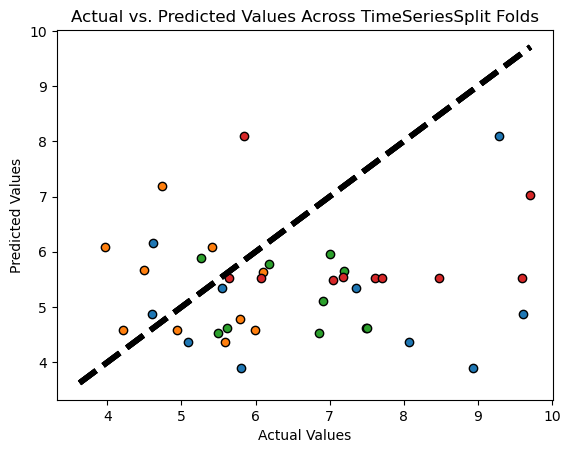

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# Iterate over folds, split data, train model, make predictions and plot
for train_index, test_index in tscv.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Train the model on the training fold
    best_ada.fit(X_train_fold, y_train_fold)

    # Make predictions on the test fold
    fold_pred = best_ada.predict(X_test_fold)

    # Plot the actual vs predicted values
    ax.scatter(y_test_fold, fold_pred, edgecolors=(0, 0, 0))
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)

# Set plot labels and title
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
ax.set_title('Actual vs. Predicted Values Across TimeSeriesSplit Folds')

# Show the plot
plt.show()

### GradientBoostRegressor

In [6]:
from sklearn.ensemble import GradientBoostingRegressor

# Define GradientBoosting parameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0]  # Percentage of samples used for fitting the individual base learners
}

# Initialize the GradientBoostingRegressor
reg_gb = GradientBoostingRegressor(random_state=500)

# Initialize GridSearchCV
grid_search_gb = GridSearchCV(estimator=reg_gb, param_grid=param_grid, cv=tscv, scoring='r2')

# Fit GridSearchCV to the training data
grid_search_gb.fit(X, y)

# Retrieve the best model from GridSearchCV
best_gb = grid_search_gb.best_estimator_

# Now, let's say you have already separated your holdout set
# Assuming 'holdout_features' contains the features of the holdout set for the year 2024 without target related features
# holdout_features = holdout.drop(['Annual_Unemployment_Rate', 'Year'], axis=1)

# Make predictions on the holdout set using the best model
holdout_pred = best_gb.predict(holdout_features)
print("Predictions for holdout year (2024):", holdout_pred)

Predictions for holdout year (2024): [5.76027412]


### True v Predicted values

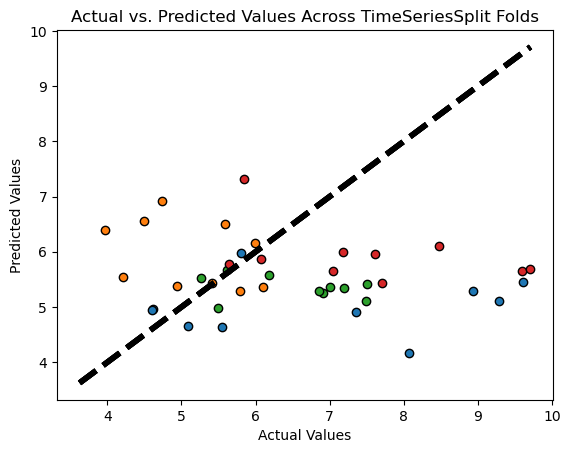

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# Iterate over folds, split data, train model, make predictions and plot
for train_index, test_index in tscv.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Train the model on the training fold
    best_gb.fit(X_train_fold, y_train_fold)

    # Make predictions on the test fold
    fold_pred = best_gb.predict(X_test_fold)

    # Plot the actual vs predicted values
    ax.scatter(y_test_fold, fold_pred, edgecolors=(0, 0, 0))
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)

# Set plot labels and title
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
ax.set_title('Actual vs. Predicted Values Across TimeSeriesSplit Folds')

# Show the plot
plt.show()

### XGBoostRegressor

In [8]:
from xgboost import XGBRegressor

# Define XGBRegressor parameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9]  # Percentage of features used per tree
}

# Initialize the XGBRegressor
reg_xgb = XGBRegressor(random_state=500)

# Initialize GridSearchCV
grid_search_xgb = GridSearchCV(estimator=reg_xgb, param_grid=param_grid, cv=tscv, scoring='r2')

# Fit GridSearchCV to the training data
grid_search_xgb.fit(X, y)

# Retrieve the best model from GridSearchCV
best_xgb = grid_search_xgb.best_estimator_

# Now, let's say you have already separated your holdout set
# Assuming 'holdout_features' contains the features of the holdout set for the year 2024 without target related features
# holdout_features = holdout.drop(['Annual_Unemployment_Rate', 'Year'], axis=1)

# Make predictions on the holdout set using the best model
holdout_pred = best_xgb.predict(holdout_features)
print("Predictions for holdout year (2024):", holdout_pred)

Predictions for holdout year (2024): [5.5058093]


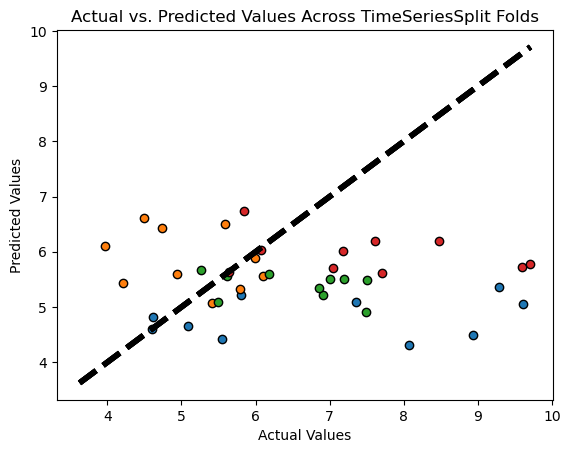

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# Iterate over folds, split data, train model, make predictions and plot
for train_index, test_index in tscv.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    # Train the model on the training fold
    best_xgb.fit(X_train_fold, y_train_fold)

    # Make predictions on the test fold
    fold_pred = best_xgb.predict(X_test_fold)

    # Plot the actual vs predicted values
    ax.scatter(y_test_fold, fold_pred, edgecolors=(0, 0, 0))
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)

# Set plot labels and title
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
ax.set_title('Actual vs. Predicted Values Across TimeSeriesSplit Folds')

# Show the plot
plt.show()

# Classification Models

## Target Variable: Binary Indicator variable for an increase
- 1: the unemployment rate increased
- 0: the unemployment rate stayed the same or decreased

In [10]:
# Define the features and target without the holdout year
X = df_modeling.drop(['Annual_Unemployment_Rate', 'Year', 'Unemployment_Rate_Increased', 'Unemployment_Rate_Percent_Change', 'Unemployment_Rate_Change_Indicator'], axis=1) # should year be included?? Is it better to include as t starting with t = 0... t+1
y = df_modeling['Unemployment_Rate_Increased']

# Initialize TimeSeriesSplit with the desired number of splits
# 40 training and 10 test observations, need to create 4 splits.
tscv = TimeSeriesSplit(n_splits=4)

### AdaBoostClassifier

In [11]:
from sklearn.ensemble import AdaBoostClassifier

# Define AdaBoost parameters to tune
param_grid = {
    'n_estimators': [5, 10, 50, 100, 150, 200],
    'learning_rate': [0.005, 0.01, 0.1, 0.5, 1.0]
}

# Initialize the AdaBoostClassifier
clf_ada = AdaBoostClassifier(random_state=500)

# Initialize GridSearchCV with 'accuracy' as the scoring metric
grid_search_clf = GridSearchCV(estimator=clf_ada, param_grid=param_grid, cv=tscv, scoring='roc_auc') # maybe try roc_auc or average_precision as scoring parameter

# Fit GridSearchCV to the training data
grid_search_clf.fit(X, y)

# Retrieve the best model
best_ada_clf = grid_search_clf.best_estimator_

# Make predictions on the holdout set using the best model
holdout_pred = best_ada_clf.predict(holdout_features)
print("Predictions for holdout year (2024):", holdout_pred)

Predictions for holdout year (2024): [0]


wrong

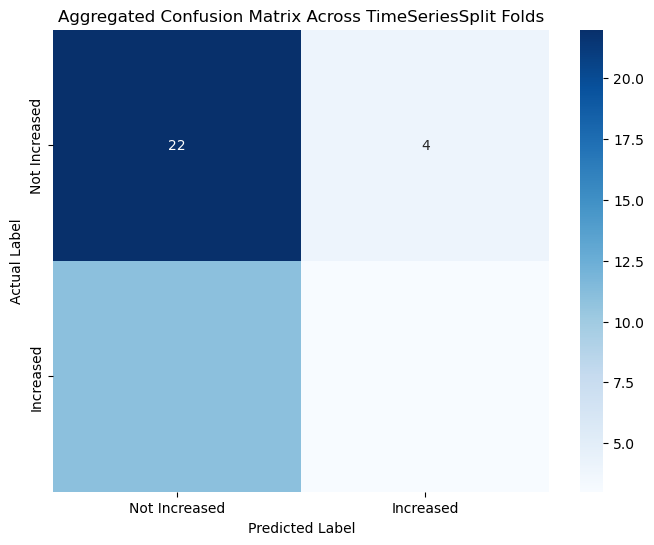

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

true_labels = []
fold_predictions = []

for train_index, test_index in tscv.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    # Train the classifier and predict on the test fold
    best_ada_clf.fit(X_train_fold, y_train_fold)
    fold_pred = best_ada_clf.predict(X_test_fold)
    
    # Append true labels and predictions to the lists
    true_labels.extend(y_test_fold)
    fold_predictions.extend(fold_pred)

# Now we can create the confusion matrix based on the aggregated fold predictions
cm = confusion_matrix(true_labels, fold_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Increased', 'Increased'],
            yticklabels=['Not Increased', 'Increased'])
plt.title('Aggregated Confusion Matrix Across TimeSeriesSplit Folds')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

### GradientBoostingClassifier

In [13]:
from sklearn.ensemble import GradientBoostingClassifier

# Define GradientBoosting parameters to tune
param_grid = {
    'n_estimators': [5, 10, 50, 100, 200, 300],
    'learning_rate': [0.01, 0.02, 0.1, 0.2, 0.3, 0.5],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]  # Percentage of samples used for fitting the individual base learners
}

# Initialize the GradientBoostingClassifier
clf_gb = GradientBoostingClassifier(random_state=500)

# Initialize GridSearchCV with 'accuracy' as the scoring metric
grid_search_clf_gb = GridSearchCV(estimator=clf_gb, param_grid=param_grid, cv=tscv, scoring='roc_auc') # maybe try roc_auc or average_precision as scoring parameter

# Fit GridSearchCV to the training data
grid_search_clf_gb.fit(X, y)

# Retrieve the best model from GridSearchCV
best_gb_clf = grid_search_clf_gb.best_estimator_

# Make predictions on the holdout set using the best model
holdout_pred = best_gb_clf.predict(holdout_features)
print("Predictions for holdout year (2024):", holdout_pred)

Predictions for holdout year (2024): [0]


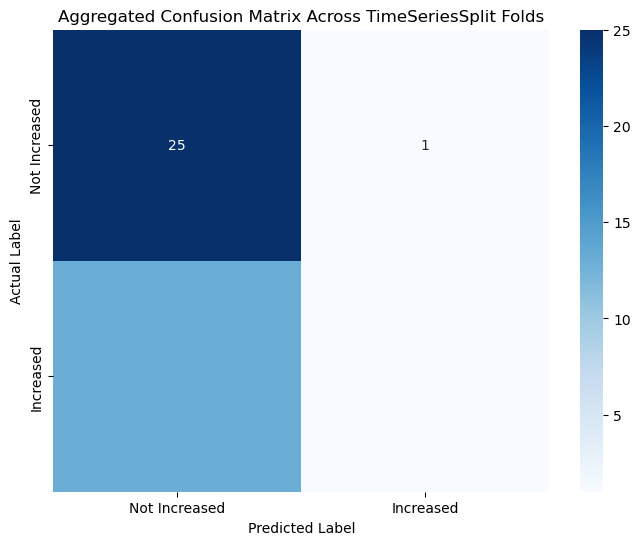

In [14]:
true_labels = []
fold_predictions = []

for train_index, test_index in tscv.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    # Train the classifier and predict on the test fold
    best_gb_clf.fit(X_train_fold, y_train_fold)
    fold_pred = best_gb_clf.predict(X_test_fold)
    
    # Append true labels and predictions to the lists
    true_labels.extend(y_test_fold)
    fold_predictions.extend(fold_pred)

# Now we can create the confusion matrix based on the aggregated fold predictions
cm = confusion_matrix(true_labels, fold_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Increased', 'Increased'],
            yticklabels=['Not Increased', 'Increased'])
plt.title('Aggregated Confusion Matrix Across TimeSeriesSplit Folds')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

wrong

### XGBoostingClassifier

In [15]:
from xgboost import XGBClassifier

# Define XGBClassifier parameters to tune
param_grid = {
     'n_estimators': [5, 10, 50, 100, 200, 300],
    'learning_rate': [0.01, 0.02, 0.1, 0.2, 0.3, 0.5],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5,0.6,0.7, 0.8, 0.9]  # Percentage of features used per tree
}

# Initialize the XGBClassifier
clf_xgb = XGBClassifier(random_state=500, use_label_encoder=False, eval_metric='logloss')

# Initialize GridSearchCV with 'accuracy' as the scoring metric
grid_search_clf_xgb = GridSearchCV(estimator=clf_xgb, param_grid=param_grid, cv=tscv, scoring='roc_auc') # maybe try roc_auc or average_precision as scoring parameter

# Fit GridSearchCV to the training data
grid_search_clf_xgb.fit(X, y)

# Retrieve the best model from GridSearchCV
best_xgb_clf = grid_search_clf_xgb.best_estimator_

# Make predictions on the holdout set using the best model
holdout_pred = best_xgb_clf.predict(holdout_features)
print("Predictions for holdout year (2024):", holdout_pred)

Predictions for holdout year (2024): [0]


wrong

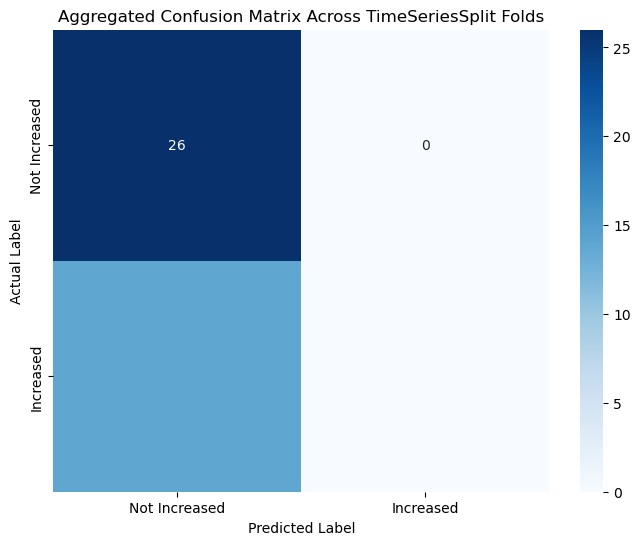

In [16]:
true_labels = []
fold_predictions = []

for train_index, test_index in tscv.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    # Train the classifier and predict on the test fold
    best_xgb_clf.fit(X_train_fold, y_train_fold)
    fold_pred = best_xgb_clf.predict(X_test_fold)
    
    # Append true labels and predictions to the lists
    true_labels.extend(y_test_fold)
    fold_predictions.extend(fold_pred)

# Now we can create the confusion matrix based on the aggregated fold predictions
cm = confusion_matrix(true_labels, fold_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Increased', 'Increased'],
            yticklabels=['Not Increased', 'Increased'])
plt.title('Aggregated Confusion Matrix Across TimeSeriesSplit Folds')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

## Target Variable: Binary Indicator variable for a 10% or greater change 
- 1: the unemployment rate changed by 10% or more from the previous year
- 0: the unemployment rate did not change by 10% or more

In [17]:
# Define the features and target without the holdout year
X = df_modeling.drop(['Annual_Unemployment_Rate', 'Year', 'Unemployment_Rate_Increased', 'Unemployment_Rate_Percent_Change', 'Unemployment_Rate_Change_Indicator'], axis=1) # should year be included?? Is it better to include as t starting with t = 0... t+1
y = df_modeling['Unemployment_Rate_Change_Indicator']

# Initialize TimeSeriesSplit with the desired number of splits
# 40 training and 10 test observations, need to create 4 splits.
tscv = TimeSeriesSplit(n_splits=4)

### AdaBoostClassifier

In [18]:
from sklearn.ensemble import AdaBoostClassifier

# Define AdaBoost parameters to tune
param_grid = {
    'n_estimators': [5, 10, 50, 100, 150, 200],
    'learning_rate': [0.005, 0.01, 0.1, 0.5, 1.0]
}

# Initialize the AdaBoostClassifier
clf_ada = AdaBoostClassifier(random_state=500)

# Initialize GridSearchCV with 'accuracy' as the scoring metric
grid_search_clf = GridSearchCV(estimator=clf_ada, param_grid=param_grid, cv=tscv, scoring='roc_auc') # maybe try roc_auc or average_precision as scoring parameter

# Fit GridSearchCV to the training data
grid_search_clf.fit(X, y)

# Retrieve the best model
best_ada_clf = grid_search_clf.best_estimator_

# Make predictions on the holdout set using the best model
holdout_pred = best_ada_clf.predict(holdout_features)
print("Predictions for holdout year (2024):", holdout_pred)

Predictions for holdout year (2024): [0]


correct

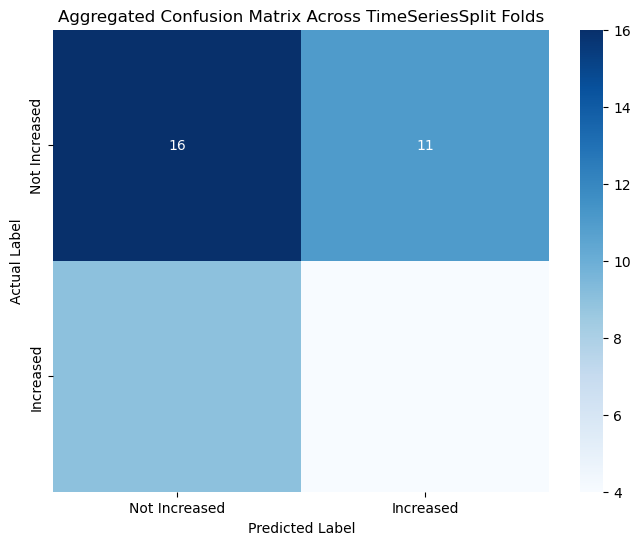

In [19]:
true_labels = []
fold_predictions = []

for train_index, test_index in tscv.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    # Train the classifier and predict on the test fold
    best_ada_clf.fit(X_train_fold, y_train_fold)
    fold_pred = best_ada_clf.predict(X_test_fold)
    
    # Append true labels and predictions to the lists
    true_labels.extend(y_test_fold)
    fold_predictions.extend(fold_pred)

# Now we can create the confusion matrix based on the aggregated fold predictions
cm = confusion_matrix(true_labels, fold_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Increased', 'Increased'],
            yticklabels=['Not Increased', 'Increased'])
plt.title('Aggregated Confusion Matrix Across TimeSeriesSplit Folds')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

### GradientBoostingClassifier

In [20]:
from sklearn.ensemble import GradientBoostingClassifier

# Define GradientBoosting parameters to tune
param_grid = {
    'n_estimators': [5, 10, 50, 100, 200, 300],
    'learning_rate': [0.01, 0.02, 0.1, 0.2, 0.3, 0.5],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]  # Percentage of samples used for fitting the individual base learners
}

# Initialize the GradientBoostingClassifier
clf_gb = GradientBoostingClassifier(random_state=500)

# Initialize GridSearchCV with 'accuracy' as the scoring metric
grid_search_clf_gb = GridSearchCV(estimator=clf_gb, param_grid=param_grid, cv=tscv, scoring='roc_auc') # maybe try roc_auc or average_precision as scoring parameter

# Fit GridSearchCV to the training data
grid_search_clf_gb.fit(X, y)

# Retrieve the best model from GridSearchCV
best_gb_clf = grid_search_clf_gb.best_estimator_

# Make predictions on the holdout set using the best model
holdout_pred = best_gb_clf.predict(holdout_features)
print("Predictions for holdout year (2024):", holdout_pred)

Predictions for holdout year (2024): [0]


correct

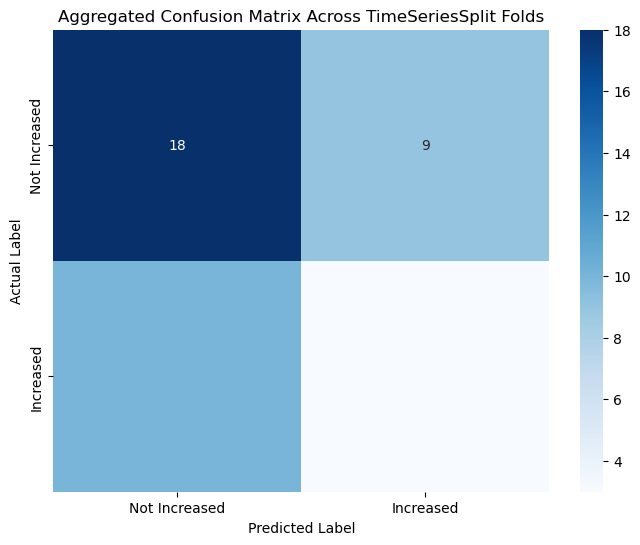

In [21]:
true_labels = []
fold_predictions = []

for train_index, test_index in tscv.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    # Train the classifier and predict on the test fold
    best_gb_clf.fit(X_train_fold, y_train_fold)
    fold_pred = best_gb_clf.predict(X_test_fold)
    
    # Append true labels and predictions to the lists
    true_labels.extend(y_test_fold)
    fold_predictions.extend(fold_pred)

# Now we can create the confusion matrix based on the aggregated fold predictions
cm = confusion_matrix(true_labels, fold_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Increased', 'Increased'],
            yticklabels=['Not Increased', 'Increased'])
plt.title('Aggregated Confusion Matrix Across TimeSeriesSplit Folds')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

### XGBoostingClassifier

In [22]:
from xgboost import XGBClassifier

# Define XGBClassifier parameters to tune
param_grid = {
    'n_estimators': [5, 10, 50, 100, 200, 300],
    'learning_rate': [0.01, 0.02, 0.1, 0.2, 0.3, 0.5],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5,0.6,0.7, 0.8, 0.9]  # Percentage of features used per tree
}

# Initialize the XGBClassifier
clf_xgb = XGBClassifier(random_state=500, use_label_encoder=False, eval_metric='logloss')

# Initialize GridSearchCV with 'accuracy' as the scoring metric
grid_search_clf_xgb = GridSearchCV(estimator=clf_xgb, param_grid=param_grid, cv=tscv, scoring='roc_auc') # maybe try roc_auc or average_precision as scoring parameter

# Fit GridSearchCV to the training data
grid_search_clf_xgb.fit(X, y)

# Retrieve the best model from GridSearchCV
best_xgb_clf = grid_search_clf_xgb.best_estimator_

# Make predictions on the holdout set using the best model
holdout_pred = best_xgb_clf.predict(holdout_features)
print("Predictions for holdout year (2024):", holdout_pred)

Predictions for holdout year (2024): [0]


correct

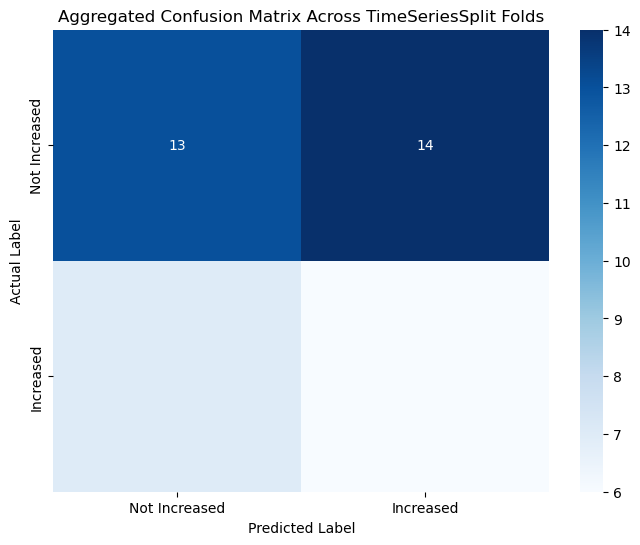

In [23]:
true_labels = []
fold_predictions = []

for train_index, test_index in tscv.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    # Train the classifier and predict on the test fold
    best_xgb_clf.fit(X_train_fold, y_train_fold)
    fold_pred = best_xgb_clf.predict(X_test_fold)
    
    # Append true labels and predictions to the lists
    true_labels.extend(y_test_fold)
    fold_predictions.extend(fold_pred)

# Now we can create the confusion matrix based on the aggregated fold predictions
cm = confusion_matrix(true_labels, fold_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Increased', 'Increased'],
            yticklabels=['Not Increased', 'Increased'])
plt.title('Aggregated Confusion Matrix Across TimeSeriesSplit Folds')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()